# Leafsnap train/test/validation split

This notebook takes the 30 species Leafsnap subset and creates a train, test, and validation dataset using symbolic links to the original images.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
dataset_path = os.path.expanduser('~/projects/DIANNA/datasets/leafsnap/leafsnap-dataset-30subset')

output_path = os.path.join(dataset_path, 'dataset', 'split')
metadata_file = os.path.join(dataset_path, 'leafsnap-dataset-30subset-images.txt')

try:
    os.makedirs(output_path)
except FileExistsError:
    print(f'Output path ({output_path}) already exists, please remove it before running this script')

In [3]:
# get a list of the image paths (relative to main folder of dataset) and corresponding source (field or lab) from the metadata
metadata = pd.read_csv(metadata_file, delimiter='\t')
# extract image paths. Some contain whitespace at the end, make sure to remove this
images = metadata['image_path'].apply(lambda value: value.strip())
sources = metadata['source']
# transform species name to be the same as in the image path: lower case, with _ instead of space
# only need the unique values
species = list(np.unique(metadata['species'].apply(lambda value: value.lower().replace(' ', '_')).values))

In [4]:
# define size of validation and test set
ntot = len(images)
ntest = int(.1 * ntot)
nval = int(.1 * ntot)
ntrain = ntot - ntest - nval

print(f'Total dataset size: {ntot}')
print(f'Training set size: {ntrain}')
print(f'Validation set size: {nval}')
print(f'Test set size: {ntest}')

Total dataset size: 7395
Training set size: 5917
Validation set size: 739
Test set size: 739


In [5]:
# split the data, stratified on field/lab. Afterwards, still need to check if species are roughly equally distributed in the different datasets
random_state = 42
images_trainval, images_test, sources_trainval, sources_test = train_test_split(images, sources, test_size=ntest, stratify=sources, random_state=random_state)
images_train, images_val, sources_train, sources_val = train_test_split(images_trainval, sources_trainval, test_size=nval, stratify=sources_trainval, random_state=random_state)

Text(0, 0.5, 'Fraction of dataset')

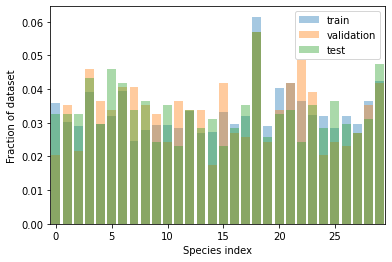

In [6]:
# show normalized species distribution in each dataset
data = {'train': images_train, 'validation': images_val, 'test': images_test}
nums = {'train': ntrain, 'validation': nval, 'test': ntest}

fig, ax = plt.subplots()

# plot each dataset
for dataset_name, images in data.items():
    # create histogram of species
    hist = np.zeros(len(species))
    # loop over elements in dataset and get species from image path
    for image_path in images:
        # extract species from path and find index in list of species
        species_index = species.index(image_path.split('/')[-2])
        hist[species_index] += 1
        
    # plot the result
    ax.bar(range(len(species)), hist / nums[dataset_name], alpha=.4, label=dataset_name)
    
ax.legend()
ax.set_xlim(-.5, len(species) - .5)
ax.set_xlabel('Species index')
ax.set_ylabel('Fraction of dataset')

In [7]:
# loop over each image in each dataset and create symlink in correct output folder
for dataset_name, image_paths in data.items():
    for img in image_paths:
        rest, img_name = os.path.split(img)
        this_species = os.path.split(rest)[-1]

        # path to original image
        source = os.path.join(dataset_path, img)
        # path to output
        destination_folder = os.path.join(output_path, dataset_name, this_species)
        os.makedirs(destination_folder, exist_ok=True)
        destination = os.path.join(destination_folder, img_name)
        # do the symlinking
        os.symlink(source, destination)